# Train recognition model

## Imports

In [29]:
import gc
import re
import json
from tqdm.auto import tqdm
from typing import List, Optional

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset

from torchvision.transforms import v2
# import albumentations as A

from torchmetrics.text import CharErrorRate, WordErrorRate

from doctr.models import recognition
from doctr.datasets import RecognitionDataset, WordGenerator, CharacterGenerator
from doctr import transforms as T

from castom_utils import (load_config,
                          Ansi, 
                          DeNormalize,
                          save_model,
                          valid_fonts, 
                          get_fonts_from_folder, 
                          get_system_fonts,
                          )

In [2]:
CFG = load_config()

Config is loaded!
A list of all characters used:
0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ €₽№°АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя


In [3]:
def draw_image_dataset(
    dataset, 
    normalize_params: Optional[dict] = None, 
    num: int = 14
):
    """
    Вывод нескольких случайных элементов из torch dataset
    """
    length = len(dataset)
    indices = np.random.choice(length, min(num, length))

    if normalize_params is not None:
        denorm = DeNormalize(**normalize_params)

    fig, axes = plt.subplots(num // 2, 2, figsize=(6, num / 2))
    fig.suptitle('augmentation images', fontweight='bold')
    for ax, idx in zip(axes.flat, indices):
        img, target = dataset[idx]

        if normalize_params is not None:
            img = denorm(img)

        img = (img * 255).to(torch.uint8)
        img = img.numpy().transpose(1, 2, 0)
        ax.set_title(target)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

In [4]:
SEED = 42

IS_CUDA = torch.cuda.is_available()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'torch use: {Ansi.green}{Ansi.bold}{DEVICE}{Ansi.end}', 
      f'({torch.cuda.get_device_name()})' 
      if torch.cuda.is_available() else '')

torch use: cuda (AMD Radeon RX 7800 XT)


In [5]:
DATASET = CFG.path_dataset_synthetic.joinpath('recognition')
BATCH_SIZE = 256

INPUT_SIZE = 32
NORMALIZE_PARAMS = dict(mean=(0.694, 0.695, 0.693), std=(0.299, 0.296, 0.301))

## Dataset 1 (word generator)

Для обучения модели подготовим два датасета. В первом датасете текст будет представлять собой случайный набор символов. Он будет использоваться для первого этапа обучения модели.

Определим список подходящих шрифтов, поддерживающих все символы из нашего набора. Шрифты можно найти, к примеру, на [Google fonts](https://fonts.google.com).

In [6]:
total_fonts = get_fonts_from_folder(CFG.path_fonts) # + get_system_fonts()
good_fonts = valid_fonts(total_fonts, CFG.vocab_unicode)
print(f"Найдено подходящих шрифтов: {Ansi.bold}{len(good_fonts)}{Ansi.end}")

Найдено подходящих шрифтов: 279


In [7]:
train_set_wg = WordGenerator(
    vocab=CFG.vocab,
    min_chars=1,
    max_chars=20,
    num_samples=10 * len(CFG.vocab),
    font_family=good_fonts,
    img_transforms=v2.Compose([
        T.Resize((INPUT_SIZE, INPUT_SIZE * 4), preserve_aspect_ratio=True),
        # Ensure we have a 90% split of white-background images
        T.RandomApply(T.ColorInversion(), .9),
        v2.RandomGrayscale(p=.1),
        v2.RandomPhotometricDistort(p=.1),
        T.RandomApply(T.RandomShadow(), p=.4),
        T.RandomApply(T.GaussianNoise(mean=0, std=.1), .1),
        T.RandomApply(v2.GaussianBlur(3), .3),
        v2.RandomPerspective(distortion_scale=.2, p=.3),
        v2.Normalize(**NORMALIZE_PARAMS),
    ]),
)

val_set_wg = WordGenerator(
    vocab=CFG.vocab,
    min_chars=1,
    max_chars=20,
    num_samples=2 * len(CFG.vocab),
    font_family=good_fonts,
    img_transforms=v2.Compose([
        T.Resize((INPUT_SIZE, INPUT_SIZE * 4), preserve_aspect_ratio=True),
        # Ensure we have a 90% split of white-background images
        T.RandomApply(T.ColorInversion(), .9),
        v2.Normalize(**NORMALIZE_PARAMS),
    ]),
)

print(f'train size: {len(train_set_wg)}')
print(f'val size:   {len(val_set_wg)}')

train size: 1130
val size:   226


In [8]:
train_loader_wg = DataLoader(
    train_set_wg,
    batch_size=BATCH_SIZE,
    drop_last=True,
    shuffle=True,
    pin_memory=IS_CUDA,
    collate_fn=train_set_wg.collate_fn,
)

val_loader_wg = DataLoader(
    val_set_wg,
    batch_size=BATCH_SIZE,
    drop_last=False,
    shuffle=False,
    pin_memory=IS_CUDA,
    collate_fn=val_set_wg.collate_fn,
)

Примеры получившихся изображений.

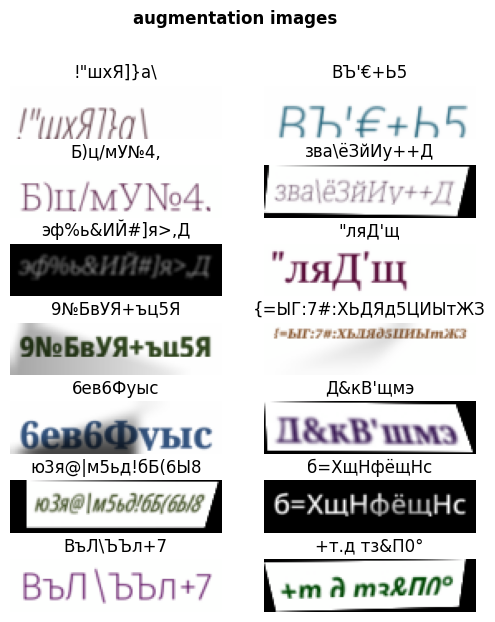

In [9]:
draw_image_dataset(train_set_wg, NORMALIZE_PARAMS)

## Dataset 2 (word from wiki)

Второй датасет сформируем из заранее сгенерированных изображений с осмысленным текстом. Процесс подготовки такого датасета рассмотрен в ноутбуке **[synthetic_datasets.ipynb](synthetic_datasets.ipynb)**.

In [10]:
train_set = RecognitionDataset(
    DATASET.joinpath('train', 'images'),
    DATASET.joinpath('train', 'labels.json'),
    img_transforms=v2.Compose([
        T.Resize((INPUT_SIZE, INPUT_SIZE * 4), preserve_aspect_ratio=True),
        T.RandomApply(T.ColorInversion(), .1),
        v2.RandomGrayscale(p=.1),
        v2.RandomPhotometricDistort(p=.1),
        T.RandomApply(T.RandomShadow(), p=.4),
        T.RandomApply(T.GaussianNoise(mean=0, std=.1), .1),
        T.RandomApply(v2.GaussianBlur(3), .3),
        v2.RandomPerspective(distortion_scale=.2, p=.3),
        v2.Normalize(**NORMALIZE_PARAMS),
    ]),
)

val_set = RecognitionDataset(
    DATASET.joinpath('val', 'images'),
    DATASET.joinpath('val', 'labels.json'),
    img_transforms=v2.Compose([
        T.Resize((INPUT_SIZE, INPUT_SIZE * 4), preserve_aspect_ratio=True),
        v2.Normalize(**NORMALIZE_PARAMS),
    ]),
)

print(f'train size: {len(train_set)}')
print(f'val size:   {len(val_set)}')

train size: 1000000
val size:   30000


In [11]:
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    drop_last=True,
    shuffle=True,
    pin_memory=IS_CUDA,
    collate_fn=train_set.collate_fn,
)

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    drop_last=False,
    shuffle=False,
    pin_memory=IS_CUDA,
    collate_fn=val_set.collate_fn,
)

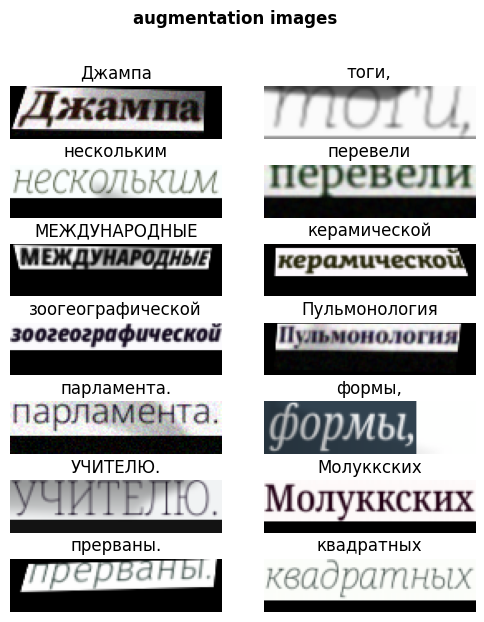

In [12]:
draw_image_dataset(train_set, NORMALIZE_PARAMS)

## Train

In [13]:
def fit_one_epoch(model, train_loader, optimizer, scheduler, epoch, eposhs):
    model.train()
    train_loss = []
    last_lr = scheduler.get_last_lr()[0]
    
    pbar = tqdm(train_loader, leave=False)
    for images, targets in pbar:
        images = images.to(DEVICE)
        
        optimizer.zero_grad()
        loss = model(images, targets)['loss']
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()

        train_loss.append(loss.detach().item())
        pbar_description = (
            f'Epoch [{epoch + 1}/{eposhs}], lr: {last_lr:.1e}, loss: {np.mean(train_loss):.4f}'
        )
        pbar.set_description(pbar_description)

    # Scheduler step
    scheduler.step()

    return pbar_description


def evaluate(model, val_loader, metric_cer, metric_wer):
    model.eval()
    metric_cer.reset()
    metric_wer.reset()
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='evaluation', leave=False)
        for images, targets in pbar:
            images = images.to(DEVICE)
            outputs = model(images)
            preds = [out[0] for out in outputs['preds']]
    
            metric_cer.update(preds, targets)
            metric_wer.update(preds, targets)

    # Вычисление итоговой метрики
    val_cer = metric_cer.compute().item()
    val_wer = metric_wer.compute().item()

    return val_cer, val_wer


def main_fit(
    eposhs, 
    model, 
    train_loader, 
    val_loader, 
    optimizer, 
    scheduler, 
    metric_cer, 
    metric_wer, 
    exp_name
):
    gc.collect()
    torch.cuda.empty_cache()
    best_cer = None
    
    for epoch in range(eposhs):
        # train
        pbar_description = fit_one_epoch(model, train_loader, optimizer, scheduler, epoch, eposhs)
    
        # val
        val_cer, val_wer = evaluate(model, val_loader, metric_cer, metric_wer)
    
        # Вывод результатов обучения для эпохи
        print(
            pbar_description, 
            f"| CER: {Ansi.bold}{val_cer:.4f}{Ansi.end},",
            f"WER: {Ansi.bold}{val_wer:.4f}{Ansi.end}",
            end = ' '
        )
    
        # Save best model
        if best_cer is None or best_cer > val_cer:
            best_cer = val_cer
            save_model(model, optimizer, scheduler, CFG.path_models_save, f'best_{exp_name}')
            print(f'{Ansi.bold}{Ansi.green}save model{Ansi.end}')
    
        # Save last model
        save_model(model, optimizer, scheduler, CFG.path_models_save, f'last_{exp_name}')

In [14]:
# Загрузим модель
model = recognition.vitstr_small(pretrained=True, vocab=CFG.vocab).to(DEVICE)

/home/lake/anaconda3/envs/lime/lib/python3.11/site-packages/doctr/models/utils/pytorch.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(archive_p

In [15]:
# Загрузим обученные веса
load_state = torch.load(
    CFG.path_models_best.joinpath('best_vitstr_small.pth'), 
    map_location=DEVICE, 
    weights_only=True
)
model.load_state_dict(load_state['model'])

<All keys matched successfully>

In [16]:
# # Сохранение текущего состояния requires_grad
# original_requires_grad = {name: param.requires_grad for name, param in model.named_parameters()}

# # Заморозить все слои
# for param in model.parameters():
#     param.requires_grad = False

# # Разморозить только выходные слои (например, model.head)
# for param in model.head.parameters():
#     param.requires_grad = True

# # Проверить, какие слои активны
# print("After modification:")
# for name, param in model.named_parameters():
#     print(f"{name}: requires_grad={param.requires_grad}")

# # Восстановить исходное состояние
# for name, param in model.named_parameters():
#     param.requires_grad = original_requires_grad[name]

# # Проверить восстановление
# print("After restoration:")
# for name, param in model.named_parameters():
#     print(f"{name}: requires_grad={param.requires_grad}")

In [18]:
metric_cer = CharErrorRate()
metric_wer = WordErrorRate()

### 1 stage

Обучение модели на первом наборе данных со случайным набором допустимых символов.

In [17]:
parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(parameters, lr=8e-4, betas=(0.95, 0.99), eps=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.6)

# optimizer.load_state_dict(load_state['optimizer'])
# scheduler.load_state_dict(load_state['scheduler'])

In [ ]:
main_fit(
    10, 
    model, 
    train_loader_wg, 
    val_loader_wg, 
    optimizer, 
    scheduler, 
    metric_cer, 
    metric_wer, 
    'vitstr_small_1'
)

### 2 stage

Обучение модели на втором наборе данных с осмысленным текстом.

In [26]:
optimizer.param_groups[0]['lr'] = 3e-4
# optimizer = optim.Adam(parameters, lr=3e-4, betas=(0.95, 0.99), eps=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.8)

In [ ]:
main_fit(
    10, 
    model, 
    train_loader, 
    val_loader, 
    optimizer, 
    scheduler, 
    metric_cer, 
    metric_wer, 
    'vitstr_small_2'
)